In [1]:
#Imports and setup

import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
todayExcelSheetPrices = pd.read_excel("NordPoolPrices_22_09_2022.xlsx", decimal=",")
tomorrowExcelSheetPrices = pd.read_excel("NordPoolPrices_23_09_2022.xlsx", decimal = ",")

todayExcelConsumption = pd.read_excel("NordPoolConsumption_22_09_2022.xlsx", decimal=",", thousands = " ")
tomorrowExcelConsumption = pd.read_excel("NordPoolConsumption_23_09_2022.xlsx", decimal=",", thousands = " ")
todayExcelSheetPrices

TypeError: read_excel() got an unexpected keyword argument 'decimal'

In [ ]:
todayPrices = todayExcelSheetPrices[["22-09-2022","Tr.heim"]].iloc[0:24]
todayPrices["Tr.heim"] = todayPrices["Tr.heim"].astype(float)
tomorrowPrices = tomorrowExcelSheetPrices[["23-09-2022", "Tr.heim"]].iloc[0:24]
tomorrowPrices["Tr.heim"] = tomorrowPrices["Tr.heim"].astype(float)

todayConsumption = todayExcelConsumption[["22-09-2022", "NO3"]].iloc[0:24]
todayConsumption["NO3"] = todayConsumption["NO3"].astype(float)
tomorrowConsumption = tomorrowExcelConsumption[["23-09-2022", "NO3"]].iloc[0:24]
tomorrowConsumption["NO3"] = tomorrowConsumption["NO3"].astype(float)

pricesTrondheim = pd.concat([todayPrices["Tr.heim"].rename("22-09-2022"), tomorrowPrices["Tr.heim"].rename("23-09-2022")], axis = 1)
consumptionNO3 = pd.concat([todayConsumption["NO3"].rename("22-09-2022"), tomorrowConsumption["NO3"].rename("23-09-2022")], axis = 1)

pricesTrondheim

,22-09-2022,23-09-2022
0,40.43,50.06
1,39.97,46.90
2,43.32,47.15
3,48.17,49.70
4,49.94,51.79
5,53.92,68.23
6,50.76,71.51
7,50.91,78.41
8,51.55,78.30
9,61.91,74.84


<AxesSubplot:>

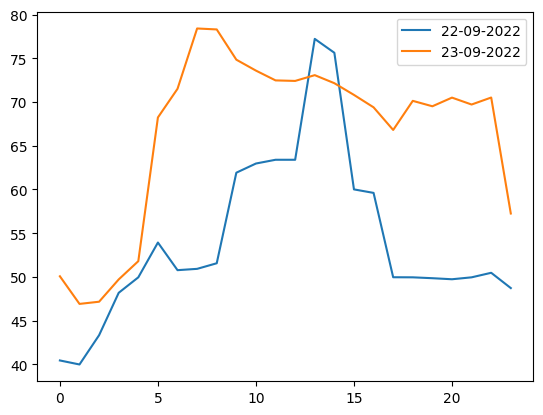

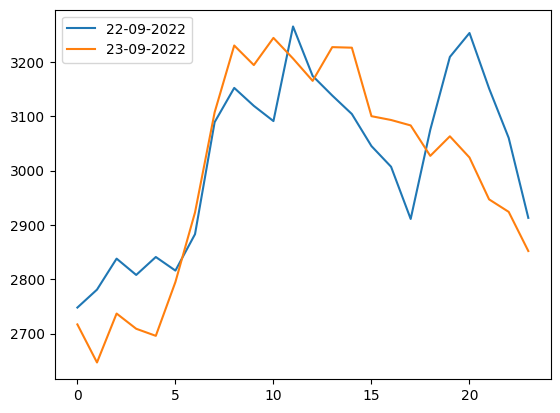

In [ ]:
pricesTrondheim.plot() #I EUR/MWh
consumptionNO3.plot() #I MWh

<AxesSubplot:>

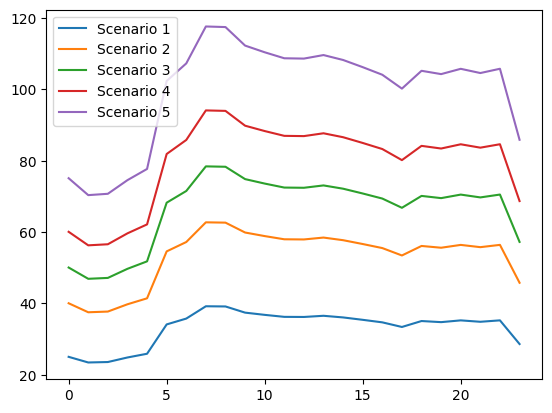

In [ ]:
#Method1 of creating future uncertainty:

nrScenarios = 5
change = [0.5, 0.8, 1, 1.2, 1.5]
probs = [0.1, 0.3, 0.3, 0.2, 0.1]

scenarios1 = pd.DataFrame()
for i in range(nrScenarios):
    scenarios1 = pd.concat([scenarios1, pricesTrondheim["23-09-2022"].rename("Scenario " + str(i+1))*change[i]], axis = 1) 
    
scenarios1.plot()

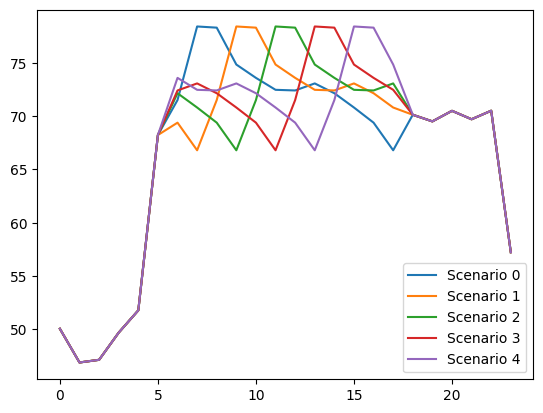

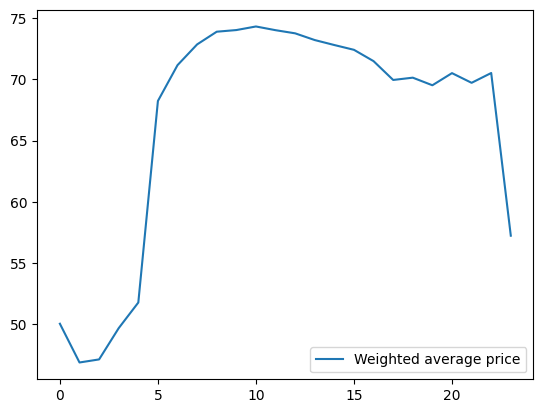

In [ ]:
#Method 2 of creating future uncertainty:

scenarios2 = pd.DataFrame()
nr_scen = 5
startTime = 6
endTime = 18

for i in range(nr_scen):
    priceChangeFromWeatherChange = np.roll(pricesTrondheim["23-09-2022"].iloc[startTime:endTime], 2*i)
    currentScen = pd.DataFrame(pricesTrondheim["23-09-2022"])
    currentScen["23-09-2022"].iloc[startTime:endTime] = priceChangeFromWeatherChange
    scenarios2 = pd.concat([scenarios2, currentScen["23-09-2022"].rename("Scenario " + str(i))], axis = 1)
    
scenarios2.plot()

probabilities = [0.4, 0.3, 0.2, 0.05, 0.05]

method2AvgPrice = []

for i in range(24):
    method2AvgPrice.append(sum(scenarios2.iloc[i].iloc[k]*probabilities[k] for k in range(nr_scen)))
    
method2AvgPrice = pd.DataFrame(method2AvgPrice)
method2AvgPrice.plot().legend(["Weighted average price"])

- Assumes Tesla model X, 
- 100kWh battery.
- Upper battery bound is 90%
- Lower battery boud is 10%
- Start charge at 50% 
- Max charge rate: 16.5 kW, https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8541926
- Max discharge rate: 16.5 kw, https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8541926
- Assumes no driving
- Buys for NordPools prices + 5.95 EUR/MWh, based on this: https://www.smartenergi.com/stromavtaler/
- Sells for NordPools prices
- 735 000 people in region NO3

- Want to minimize the cost of electricity during a day (C).
- We are subject to a price when purchasing (Price_p), and a selling price (Price_s)
- Have to purchase power (Pp).
- Can sell power (Ps)
- Need to satisfy Power consumption (Pc).
- Can supply power to and from our battery (Pb)

- Objective function: 
    - minimize C = sum(price_p[i] * Pp[i] - price_s[i] * Ps[i]) for i in t = [1:48]

- Constraints:
    - Pc[i] = Pp[i] + Pb[i] - Ps[i]
    - Pb[i] <= 16.5
    - Pb[i] >= -16.5
    - E_bat[i] <= E_max
    - E_bat[i] >= E_min
    - E_bat[i] = E_bat[i-1] - Pb[i]*dt
    #Ps <= Pb
 

<AxesSubplot:>

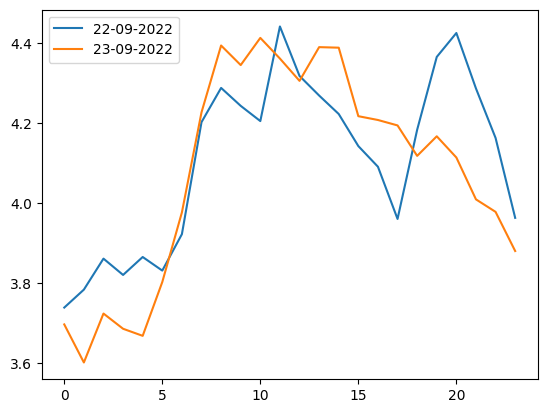

In [ ]:
consumptionPerPerson = consumptionNO3 / 735 #KWh

dt = 1 #h
E_max = 100*0.9 #kWh
E_min = 100*0.1 #kWh
E_0 = 100*0.5 #kWh
E_end = 100*0.5 #kWh
#price_s = pd.concat([pricesTrondheim["22-09-2022"]*10**-3, pricesTrondheim["23-09-2022"]*10**-3], ignore_index = 1) #Standard, non stochastic example
price_s = pd.concat([pricesTrondheim["22-09-2022"]*10**-3, method2AvgPrice[0]*10**-3], ignore_index = 1) #Assumes scenario method 2
price_p = price_s + 5.95*10**-3
Pc = pd.concat([consumptionPerPerson["22-09-2022"], consumptionPerPerson["23-09-2022"]], ignore_index = 1)

consumptionPerPerson.plot()

In [ ]:
model = pyo.ConcreteModel() #Creates model

model.Pp = pyo.Var(range(48), within = pyo.NonNegativeReals)
model.Pb = pyo.Var(range(48), within = pyo.Reals)
model.Ps = pyo.Var(range(48), within = pyo.NonNegativeReals)
model.E_bat = pyo.Var(range(49), within = pyo.NonNegativeReals)

model.objFnc = pyo.Objective(expr = sum(price_p[i] * model.Pp[i] - price_s[i] * model.Ps[i] for i in range(48)), sense = pyo.minimize)

constraints = []

constraints.append(model.E_bat[0] == E_0)
constraints.append(model.E_bat[48] == E_end)

for i in range(48):
    constraints.append(Pc[i] == model.Pp[i] + model.Pb[i] - model.Ps[i])
    constraints.append(model.Pb[i] <= 16.5)
    constraints.append(model.Pb[i] >= -16.5)
    constraints.append(model.E_bat[i] <= E_max)
    constraints.append(model.E_bat[i] >= E_min)
    constraints.append(model.E_bat[i+1] == model.E_bat[i] - model.Pb[i]*dt)
    #constraints.append(model.Ps[i] == 0) #Allow or disallow sales
    
model.constraints = pyo.ConstraintList()
for constraint in constraints:
    model.constraints.add(expr = constraint)
    

<AxesSubplot:>

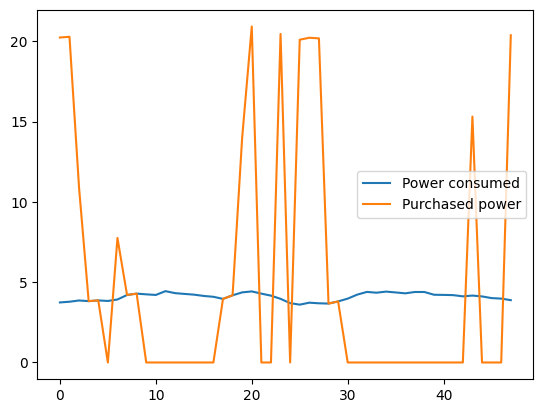

In [ ]:
#Solving the model

opt = SolverFactory("gurobi", solver_io="python")
results = opt.solve(model)

#model.display()
purchased_power = pd.DataFrame([model.Pp.get_values()[i] for i in range(48)])
powerComp = pd.concat([Pc.rename("Power consumed"), purchased_power[0].rename("Purchased power")], axis = 1)
powerComp.plot()

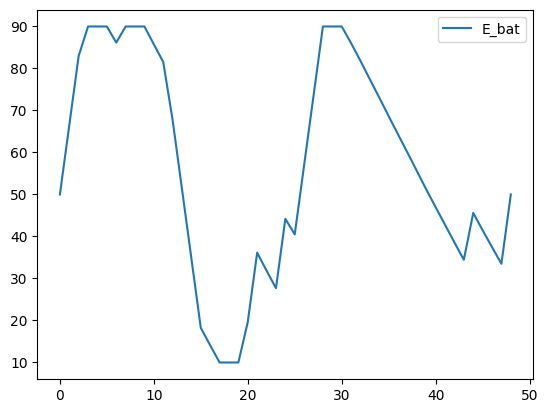

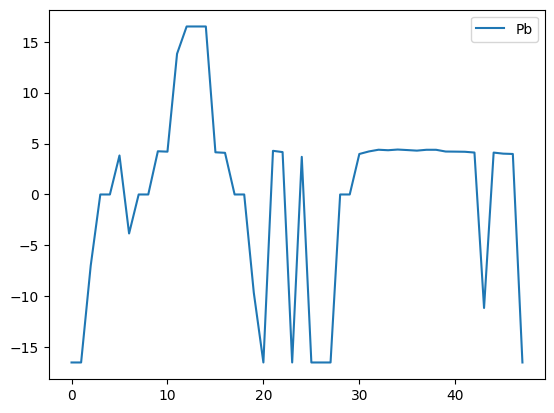

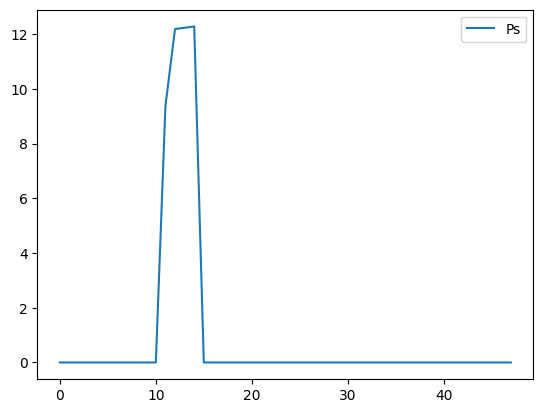

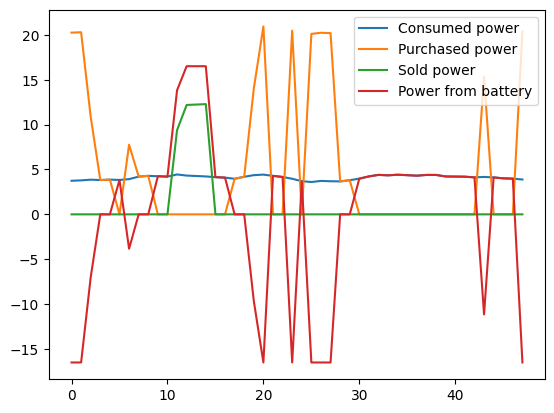

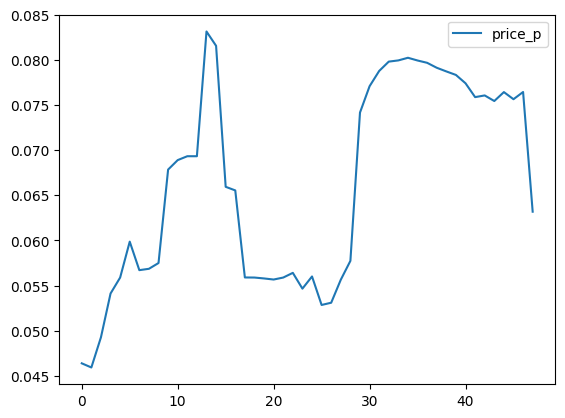

In [ ]:
E_bat = pd.DataFrame(model.E_bat.get_values()[i] for i in range(49))
Pb = pd.DataFrame(model.Pb.get_values()[i] for i in range(48))
Ps = pd.DataFrame(model.Ps.get_values()[i] for i in range(48))
Pp = pd.DataFrame(model.Pp.get_values()[i] for i in range(48))

E_bat.plot().legend(["E_bat"])
Pb.plot().legend(["Pb"])
Ps.plot().legend(["Ps"])

P = pd.concat([Pc.rename("Consumed power"), Pp[0].rename("Purchased power"), Ps[0].rename("Sold power"), Pb[0].rename("Power from battery")], axis = 1)
P.plot().legend(P.columns)
price_p = pd.DataFrame(price_p)
price_p.plot().legend(["price_p"])


In [ ]:
#Money saved: 
savings = sum(price_p.iloc[i]*Pc[i] for i in range(48)) - model.objFnc()
print(str(savings.iloc[0]) + " Euro per 48 hours")


2.8698827585033975 Euro per 48 hours
